# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

**Sumber Dataset**:  
Project ini akan menggunakan dataset berjudul "Banking Marketing"
Dataset ini bersumber dari platform [kaggle](https://www.kaggle.com/datasets/thedevastator/bank-term-deposit-predictions) dan bersumber asli dari platfrom [hugging face](https://huggingface.co/datasets/Andyrasika/banking-marketing)

**Overview Dataset**:
Dataset ini mencakup data telemarketing bank Portugal untuk memprediksi langganan deposito berjangka (`y`). Terdiri dari **45.211 sampel pelatihan** dan **4.521 sampel uji**, dengan 17 fitur mencakup profil nasabah, riwayat kontak, dan hasil kampanye sebelumnya.

Tujuan analisis adalah mengidentifikasi nasabah berpotensi konversi guna optimasi biaya telemarketing. **Meskipun dataset ini telah memiliki label, kita akan menghapus kolom label tersebut** dan akan melakukan pengelompokkan data berdasarkan karakteristik tertentu dengan algoritma K-Means hingga didapat kelompok yang merepresentasikan fakta di lapangan untuk tujuan marketing dan meningkatkan langganan.

# **2. Import Library**

Import beberapa pustaka (library) Python yang
dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
# from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

# **3. Memuat Dataset**

Data dibaca dari file CSV (train.csv) menggunakan pd.read_csv() dan disimpan dalam DataFrame df. Kolom target y (subscribtion deposit) di-drop menggunakan df.drop() karena pada tahap ini hanya fokus pada klusterisasi berdasarkan fitur.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/syafiqirz/Credit-Marketing-ML-Project/refs/heads/main/credit_terms_train.csv')
df.drop(['y'], axis = 1, inplace=True)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Akan dilakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

## 1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


**Struktur Dataset**:  
- Total entri: 45.211  
- Kolom: 16 (7 numerik, 9 kategorikal)  
- Tidak ada missing value dan duplikat (bisa dilihat pada sel berikutnya).  

**Tindakan Selanjutnya**:  
- Encoding untuk kolom kategorikal seperti `job`, `education`.  
- Pemeriksaan distribusi nilai unik pada kolom kategorikal.  
- Scaling untuk kolom numerik seperti `balance` dan `duration`.  

## 2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*).
   Setelah dicek, dataset ini tidak memiliki nilai yang hilang ataupun duplikat sehingga sudah dapat dilanjutkan ke tahap selanjutnya.


In [5]:
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [6]:
print("Jumlah baris yang duplikat: ", df.duplicated().sum())

Jumlah baris yang duplikat:  0


## 3. **Analisis Distribusi dan Korelasi**  
#### Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  

In [7]:
df.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN


**Variabel Numerik**
- age: Rentang usia nasabah 18-95 tahun (median 39 tahun).

- balance: Saldo rata-rata €1.362 (std €3.045), dengan nilai ekstrem (-€8.019 hingga €102.127).

- duration: Rata-rata durasi kontak 258 detik (≈4 menit), maksimum 4.918 detik (≈82 menit).

- campaign: Rata-rata 2-3 kontak per nasabah, tetapi ada outlier hingga 63 kontak.

- pdays: 75% data bernilai -1 (nasabah belum pernah dihubungi sebelumnya).

**Variabel Kategorik**
- Pekerjaan (job): Mayoritas "blue-collar" (9.732 nasabah).

- Status Pernikahan (marital): Terbanyak "married" (27.214 nasabah).

- Pendidikan (education): Mayoritas "secondary" (23.202 nasabah).

- Kontak (contact): Dominan via "cellular" (29.285 nasabah).

- Bulan (month): Mei ("may") paling aktif (13.766 kontak).



In [8]:
# Distribusi usia berdasarkan pekerjaan dan status pernikahan
df.groupby(['job', 'marital'])['age'].agg(['mean', 'median', 'count']).sort_values(by='count', ascending=False).head(10)

,,mean,median,count
job,marital,,,
blue-collar,married,41.549799,41.0,6968
management,married,42.684444,41.0,5400
technician,married,41.854640,41.0,4052
management,single,34.507635,33.0,2947
admin.,married,41.502414,40.0,2693
technician,single,33.924046,33.0,2620
services,married,40.692148,40.0,2407
blue-collar,single,33.550149,32.0,2014
retired,married,61.753322,59.0,1731


** Usia vs. Pekerjaan & Status (Top 10)**

Analisis usia berdasarkan pekerjaan & status (10 kelompok terbesar):

* **Menikah & Pekerjaan Manual/Teknis/Manajemen Dominan:** Usia rata-rata & median 41-43 tahun.
* **Profesional Menikah Cukup Besar:** Usia rata-rata & median ~41 tahun (Admin).
* **Profesional & Pekerja Manual Lajang Lebih Muda:** Usia rata-rata & median ~33-34 tahun (Manajemen, Admin, Blue-collar, Teknisi).
* **Pekerja Jasa Menikah:** Usia rata-rata & median ~40 tahun.
* **Pensiunan Menikah Tertua:** Usia rata-rata & median ~60-62 tahun.

**Insight:** Pekerja menikah di bidang manual, teknis, dan manajemen adalah kelompok terbesar. Profesional dan pekerja manual lajang cenderung lebih muda. Status menikah berkorelasi dengan usia dalam beberapa pekerjaan.

In [9]:
# Rata-rata balance berdasarkan pendidikan dan status pinjaman
df.groupby(['education', 'housing', 'loan'])['balance'].agg(['mean', 'median', 'count']).sort_values(by='mean', ascending=False).head(10)

,,,mean,median,count
education,housing,loan,,,
tertiary,no,no,2027.332419,664.0,6197
unknown,no,no,1839.773006,719.0,978
primary,no,no,1744.889375,604.0,2513
tertiary,yes,no,1698.900000,584.0,5320
secondary,no,no,1482.996541,478.0,7516
unknown,yes,no,1261.546917,450.0,746
secondary,yes,no,1104.015374,411.0,11383
primary,yes,no,1068.354255,367.0,3314
tertiary,yes,yes,1006.107750,332.0,1058


**Rata-rata Saldo vs. Pendidikan & Pinjaman**

Analisis menunjukkan rata-rata saldo bervariasi berdasarkan pendidikan dan status pinjaman:

* **Saldo Tertinggi:** Lulusan tersier tanpa pinjaman rumah/pribadi (~2027 Euro).
* **Pengaruh Negatif Pinjaman:** Kepemilikan pinjaman (rumah/pribadi) cenderung menurunkan rata-rata saldo.
* **Saldo Lebih Tinggi Tanpa Pinjaman:** Nasabah tanpa pinjaman rumah/pribadi umumnya memiliki saldo lebih tinggi di berbagai tingkat pendidikan.
* **Saldo Terendah dengan Pinjaman:** Kepemilikan pinjaman rumah (tanpa pinjaman pribadi) terkait dengan saldo yang lebih rendah.

**Insight:** Pendidikan tinggi dan tidak memiliki pinjaman berkorelasi dengan saldo lebih besar. Pinjaman, terutama rumah, cenderung terkait saldo lebih rendah.

In [10]:
# Frekuensi kontak berdasarkan pekerjaan
df.groupby(['job'])['campaign'].agg(['mean', 'median', 'count']).sort_values(by='mean', ascending=False)

,mean,median,count
job,,,
unknown,3.309028,2.0,288
technician,2.906805,2.0,7597
management,2.864348,2.0,9458
self-employed,2.853072,2.0,1579
housemaid,2.820968,2.0,1240
blue-collar,2.816995,2.0,9732
entrepreneur,2.799597,2.0,1487
services,2.718344,2.0,4154
admin.,2.575324,2.0,5171


### Rata-rata Frekuensi Kontak vs. Pekerjaan

Rata-rata jumlah kontak kampanye bervariasi berdasarkan pekerjaan:

* **Tertinggi:** "unknown" (3.3), "technician" (2.91), "management" (2.86).
* **Sedang:** "self-employed" - "services" (2.72 - 2.85).
* **Terendah:** "admin." - "student" (< 2.6), terendah "student" (2.30).
* **Median:** Umumnya 2 kontak.

**Insight:** Pekerjaan "unknown" dan profesional cenderung butuh lebih banyak kontak. Pelajar dan pensiunan butuh lebih sedikit. Median kontak stabil di 2.

## 4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

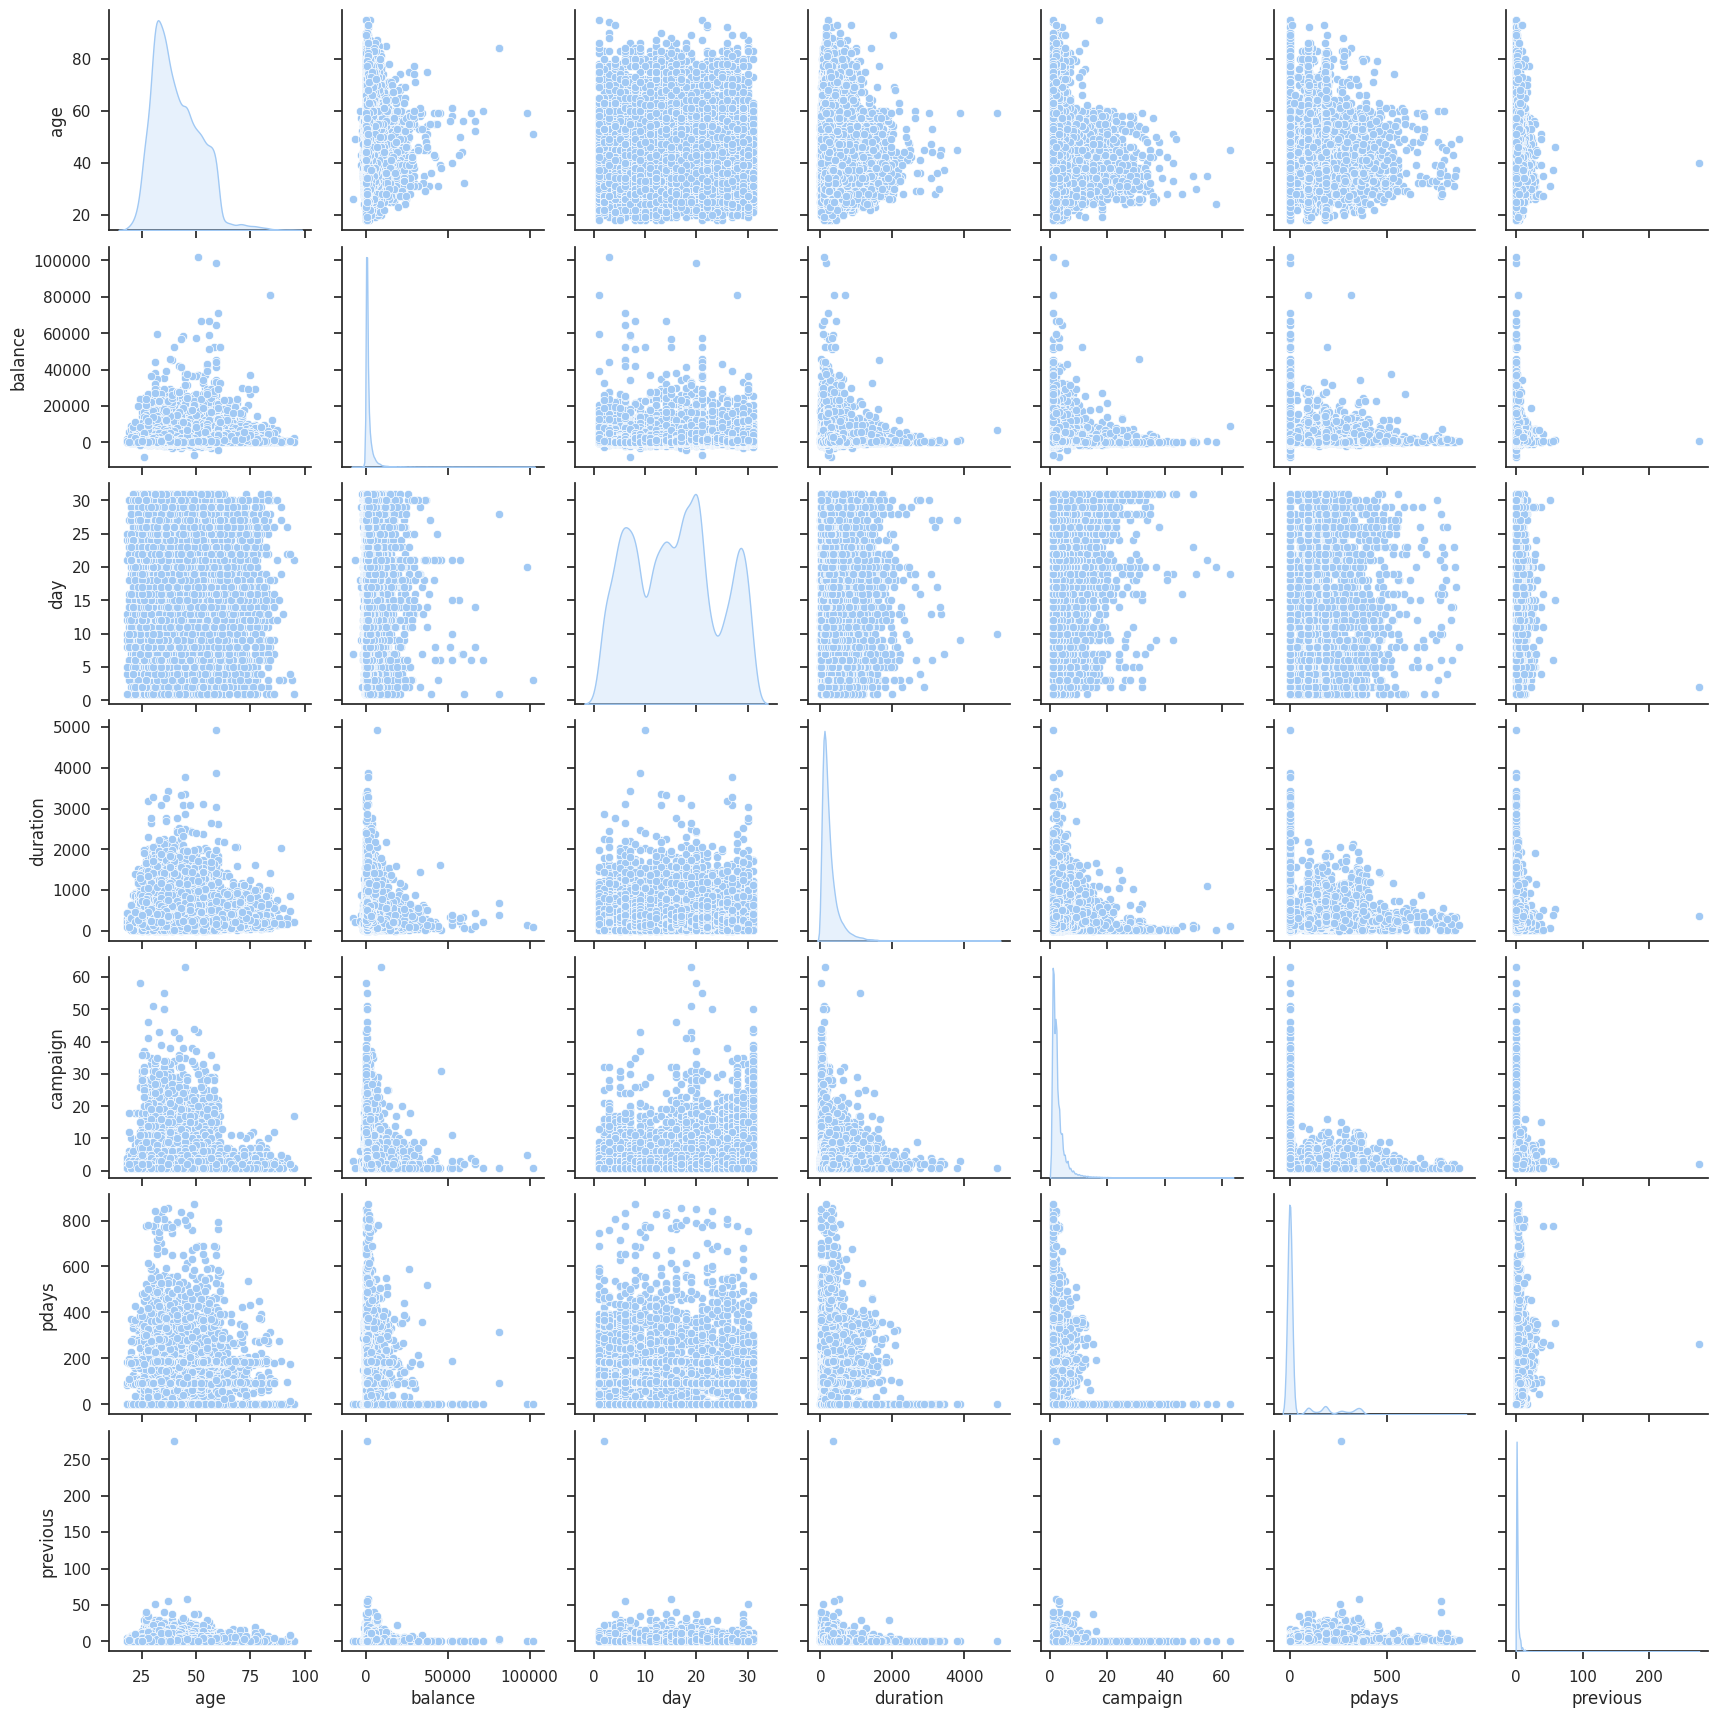

In [11]:
sns.set_theme(style="ticks", palette="pastel")

sns.pairplot(df[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']], diag_kind='kde')

plt.show()

**Analisis Visualisasi Variabel Numerik**

Visualisasi menunjukkan distribusi dan hubungan antar variabel numerik (age, balance, day, duration, campaign, pdays, previous).

**Distribusi Variabel:**

* **age:** Miring ke kanan, mayoritas 25-40 tahun.
* **balance, duration, pdays, previous:** Banyak outlier, data cenderung rendah.
* **campaign, day:** Distribusi lebih merata, ada puncak nilai tertentu.

**Korelasi dan Pola Relasi:**

* **duration:** Cenderung meningkat seiring pdays dan previous.
* **age:** Tidak ada korelasi linear kuat dengan variabel lain.

**Outlier dan Konsentrasi Data:**

* **balance, pdays, previous, duration:** Data terkonsentrasi di nilai rendah, banyak outlier signifikan.
* **pdays, previous:** Distribusi sangat tidak merata, dominasi nilai nol/rendah.

**Multikolinearitas:**

* Tidak ada indikasi multikolinearitas signifikan antar variabel.

**Kesimpulan Awal:**

Distribusi variabel bervariasi, dengan beberapa memiliki outlier. Durasi kontak terkait riwayat kontak. Usia tidak berkorelasi linear kuat dengan variabel lain. Tidak ada masalah multikolinearitas. Temuan ini penting untuk preprocessing dan pemodelan.

<Axes: >

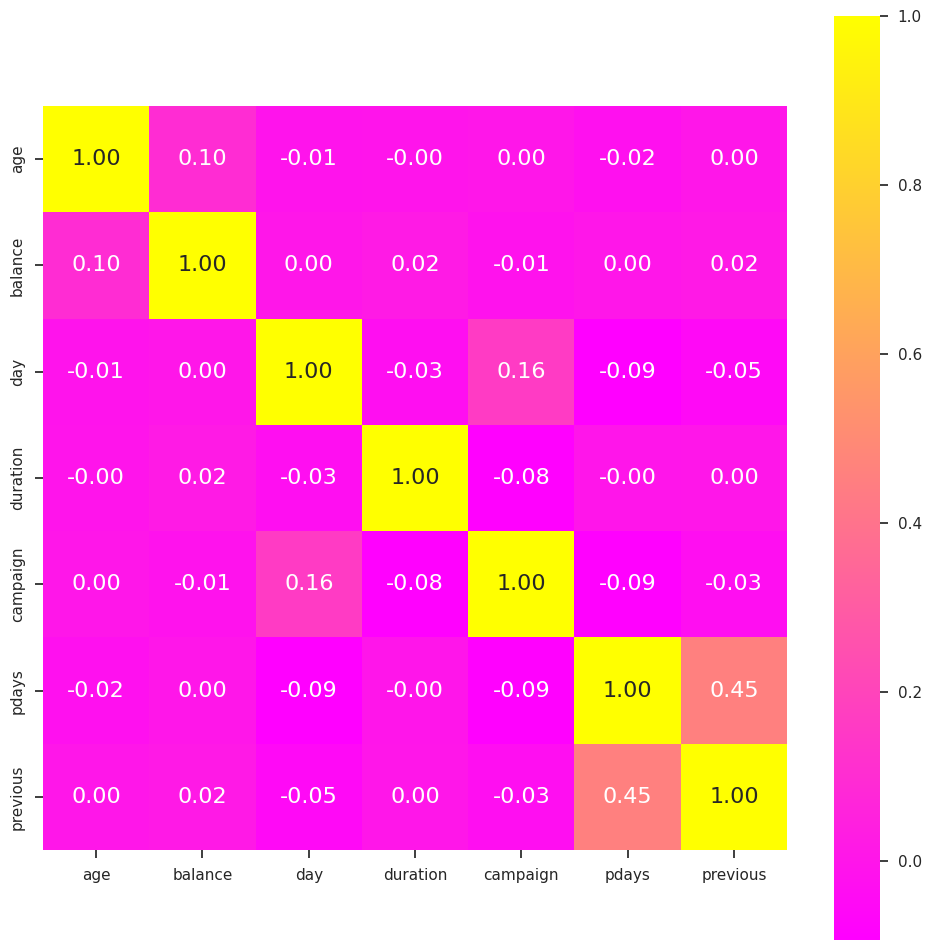

In [12]:
correlation=df[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']].corr()
plt.figure(figsize =(12, 12))

sns.heatmap(correlation, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size':16}, cmap='spring')

**Insight Heatmap Korelasi Variabel Numerik**

Heatmap korelasi menunjukkan hubungan antar variabel numerik. Temuan utama:

* **Korelasi Lemah:** Sebagian besar pasangan variabel berkorelasi sangat lemah (mendekati nol), menandakan minimnya hubungan linear kuat.

* **Korelasi Cukup Signifikan:** pdays & previous (0.45) Korelasi positif sedang. Semakin lama jeda kontak terakhir, semakin banyak kontak sebelumnya. Ini relevan untuk analisis prediktif riwayat interaksi.

* **Hubungan Tidak Signifikan:** Korelasi antara *age, balance, day, duration, campaign* dengan variabel lain sangat rendah (-0.1 hingga 0.1), menunjukkan tidak ada hubungan linear yang menonjol. Contoh: *age* hampir tidak berkorelasi dengan variabel lain.

* **Implikasi Modeling:** Karena multikolinearitas rendah, semua variabel numerik relatif aman digunakan dalam model *machine learning* tanpa risiko redundansi.

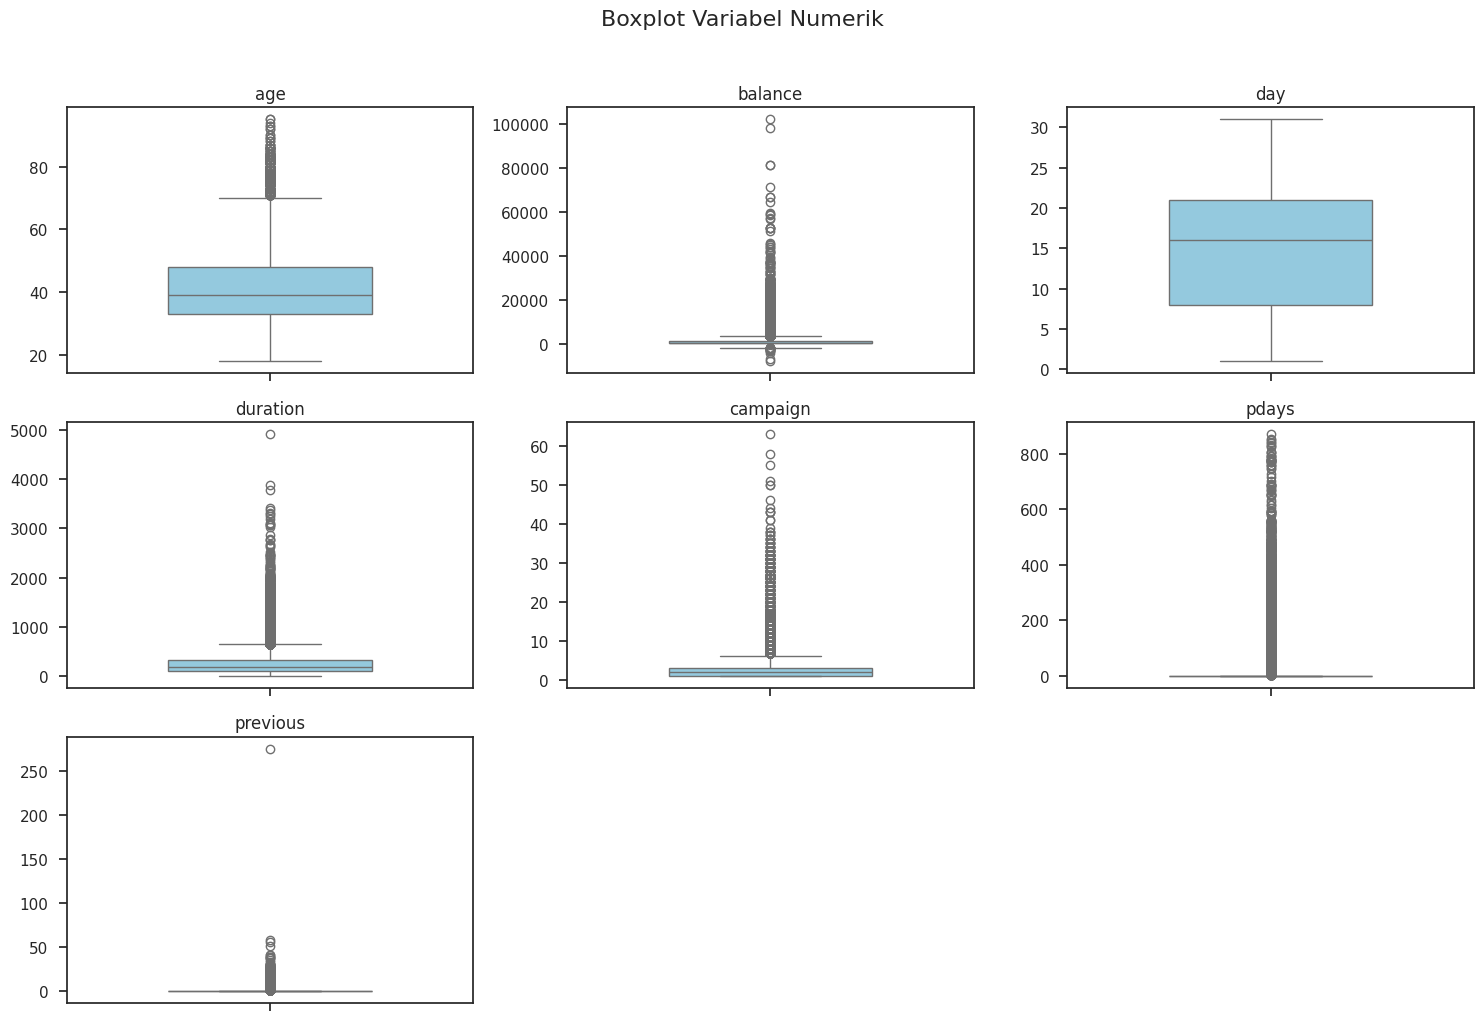

In [13]:
# Definisikan kolom numerik
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(15, 10))
plt.suptitle('Boxplot Variabel Numerik', y=1.02, fontsize=16)

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # 3 baris, 3 kolom, posisi ke-i
    sns.boxplot(data=df, y=col, color='skyblue', width=0.5)
    plt.title(col)
    plt.ylabel('')

plt.tight_layout()
plt.show()

**Insight Boxplot Variabel Numerik**

**🔍 1. Usia (age):** Distribusi normal, sedikit **outlier** di atas 70 tahun. Mayoritas nasabah usia produktif (30-50 tahun).

**🔍 2. Saldo (balance):** **Outlier** ekstrem signifikan (>100.000 Euro, mayoritas <10.000 Euro). Distribusi sangat **right-skewed**. Perlu pertimbangkan mempertahankan (signifikan bisnis) atau mentransformasi (log/normalisasi).

**🔍 3. Hari (day):** Distribusi relatif merata (1-31), tanpa **outlier**. Kontak acak dalam sebulan.

**🔍 4. Durasi (duration):** **Outlier** sangat banyak (>3000 detik, mayoritas <1000 detik). Penting untuk target (y) tapi tidak untuk prediksi (diketahui setelah kontak).

**🔍 5. Jumlah Kontak (campaign):** Banyak **outlier** (>50 kontak, mayoritas <5). Potensi **over-contacting** bisa negatif.

**🔍 6. Hari Setelah Kontak Terakhir (pdays):** Banyak nilai mendekati 1000 (tidak pernah dihubungi). Sangat **skewed**. Pertimbangkan fitur kategorikal (contoh: `prev_contact`: 0=belum, 1=pernah).

**🔍 7. Jumlah Kontak Sebelumnya (previous):** Mayoritas tidak pernah dihubungi (0), beberapa **outlier** (>200 kontak). Perlu verifikasi keaslian **outlier**.

**Kesimpulan awal:**

Banyak variabel numerik memiliki **outlier** ekstrem. Sebelum pemodelan, disarankan untuk:

* Skalakan/normalisasi data.
* Transformasi log untuk data **skewed**.
* Tangani **outlier** (winsorisasi, capping, hapus jika ekstrem).

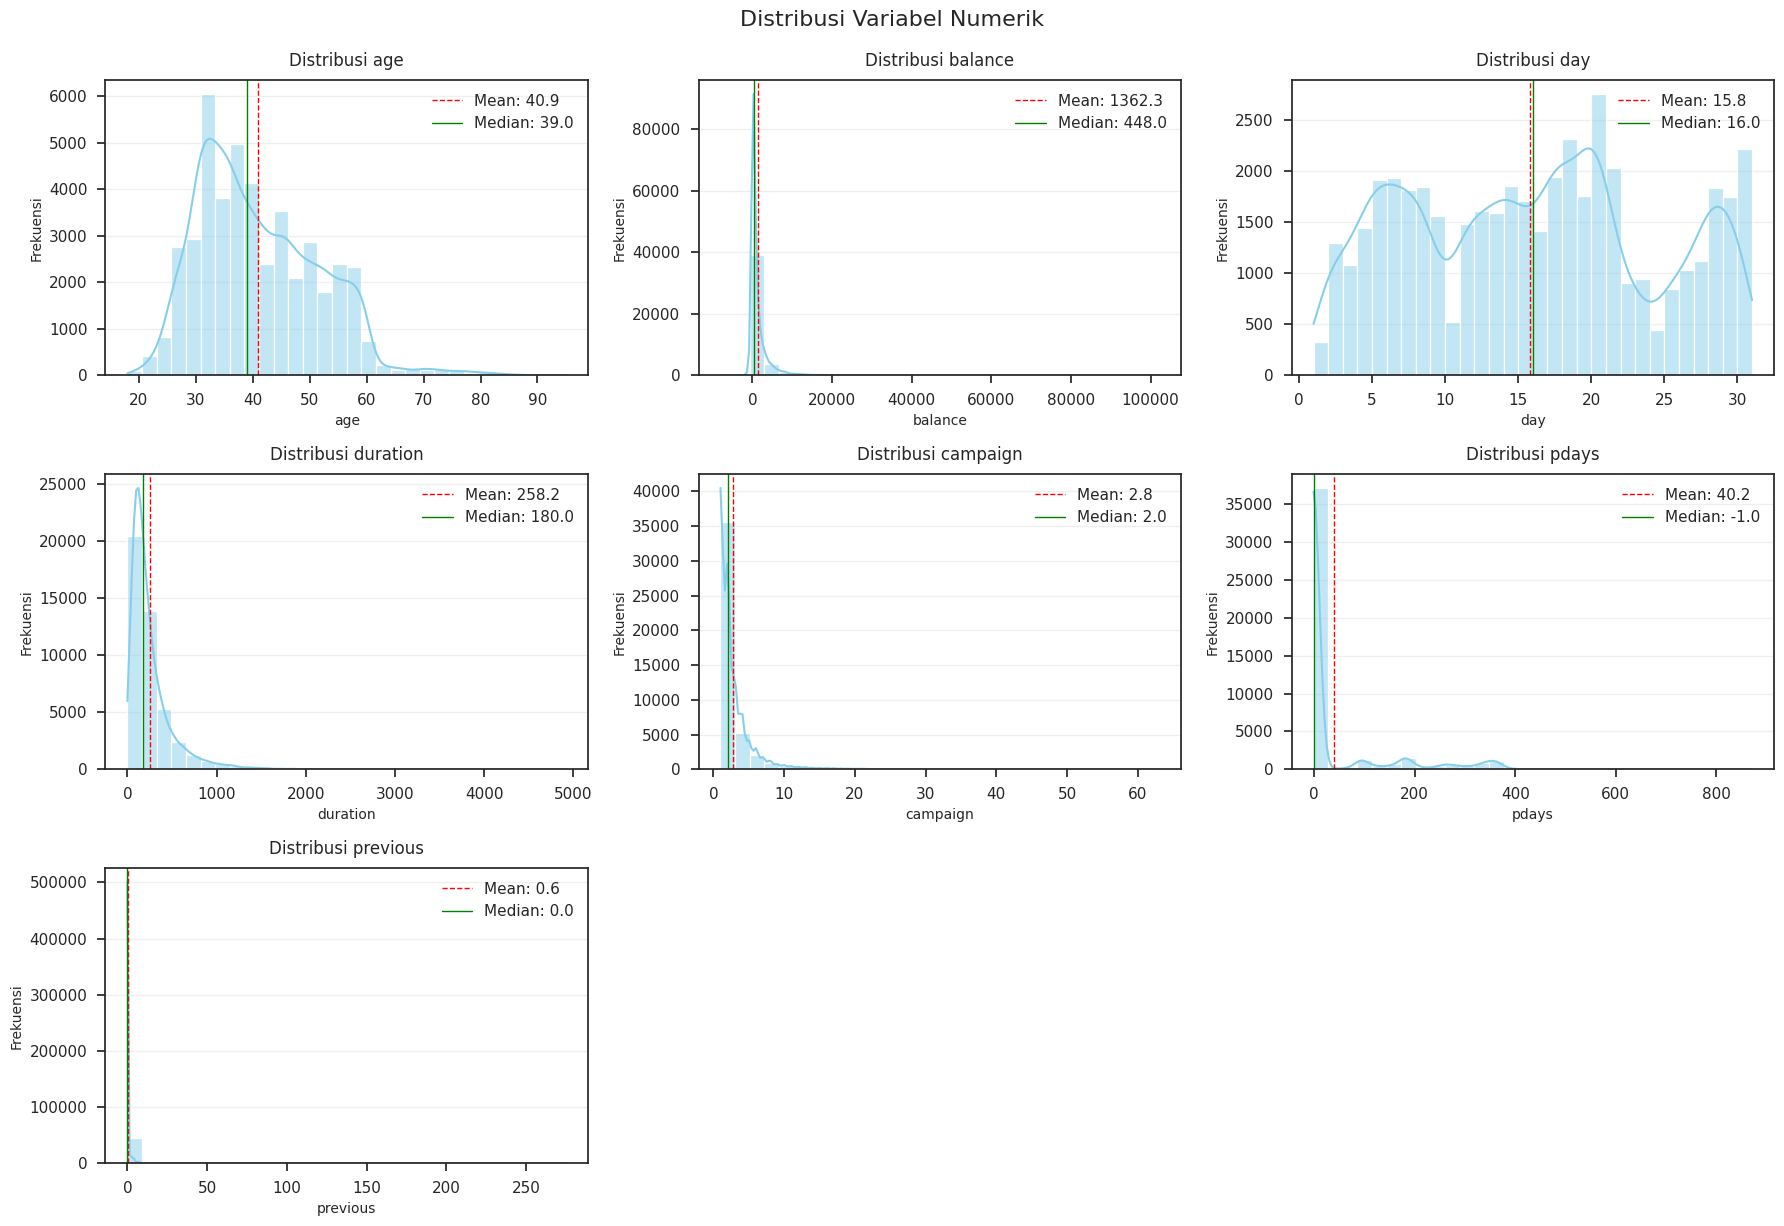

In [14]:
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(18, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')

    plt.title(f'Distribusi {col}', fontsize=12, pad=10)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frekuensi', fontsize=10)
    plt.grid(axis='y', alpha=0.3)

    mean_val = df[col].mean()
    median_val = df[col].median()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=1, label=f'Median: {median_val:.1f}')
    plt.legend()

plt.tight_layout()
plt.suptitle('Distribusi Variabel Numerik', y=1.02, fontsize=16)
plt.show()

<ipython-input-15-372e6745c7ef>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='viridis',
<ipython-input-15-372e6745c7ef>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='viridis',
<ipython-input-15-372e6745c7ef>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, palette='viridis',
<ipython-input-15-372e6745c7ef>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and s

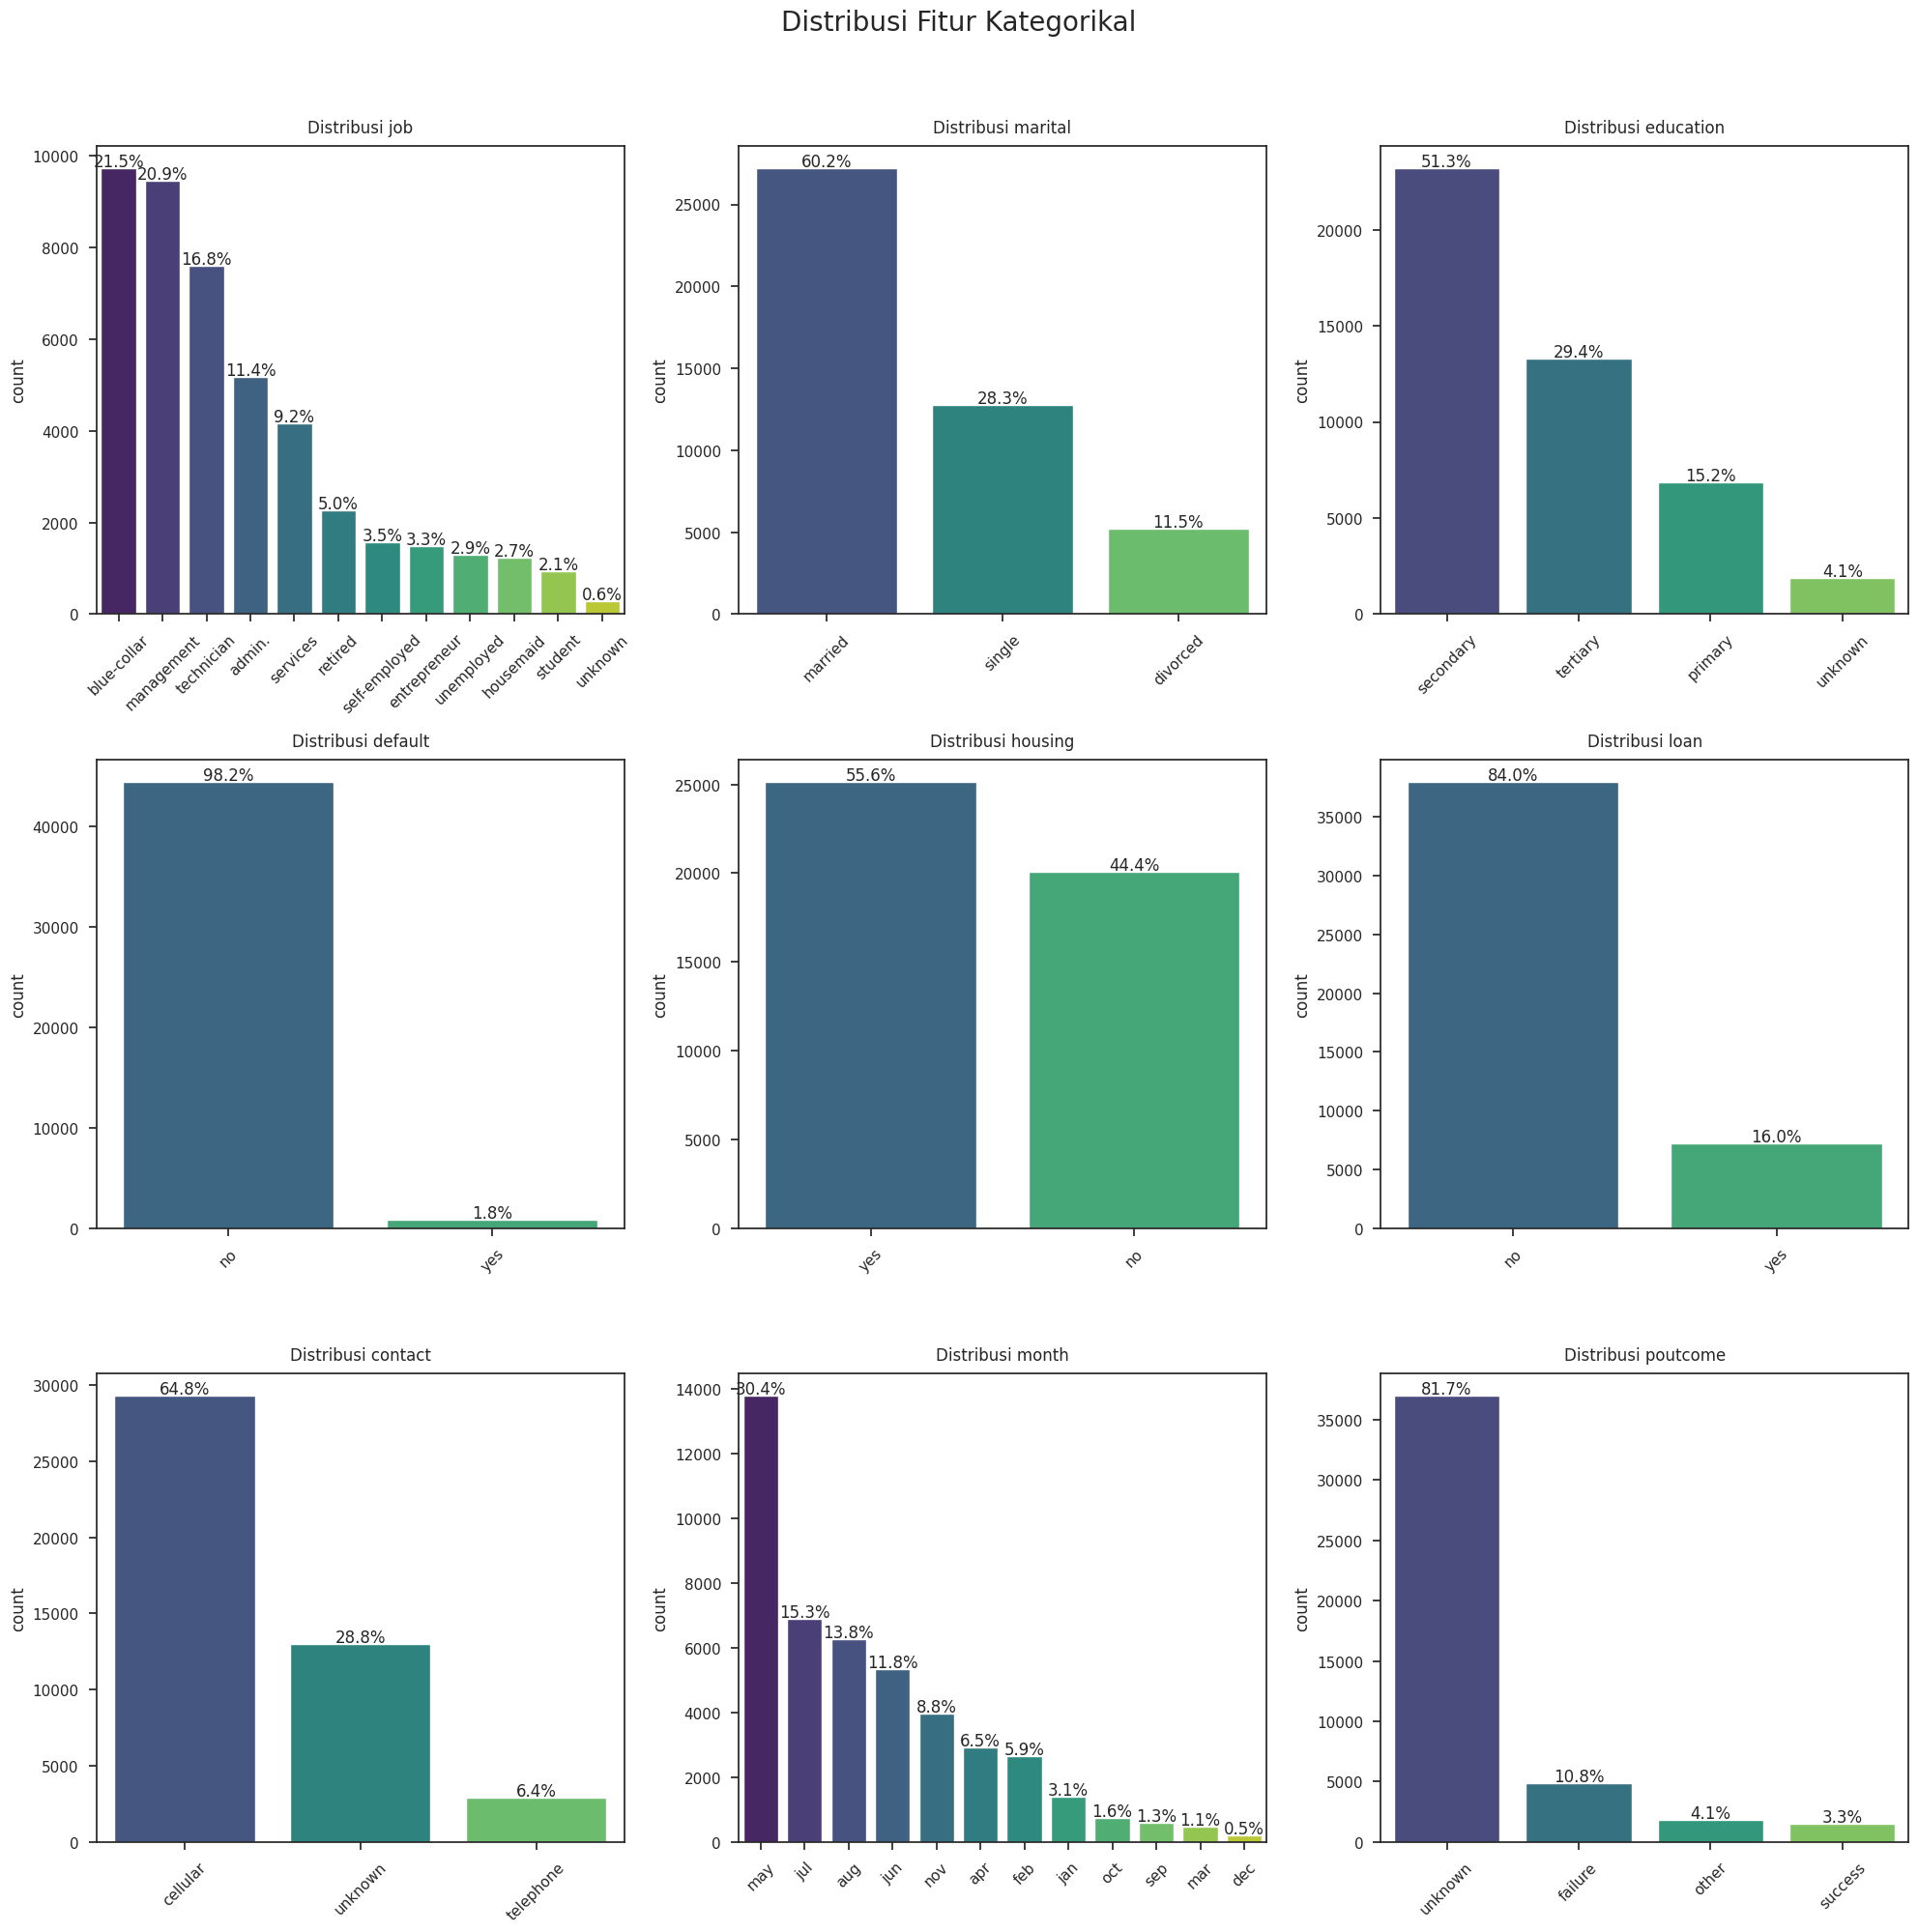

In [15]:
# List semua kolom kategorikal
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'poutcome']

plt.figure(figsize=(20, 25))
plt.suptitle('Distribusi Fitur Kategorikal', y=1.02, fontsize=20)
for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 3, i)
    ax = sns.countplot(data=df, x=col, palette='viridis',
                      order=df[col].value_counts().index)

    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height()/total:.1f}%'
        ax.annotate(percentage,
                   (p.get_x() + p.get_width()/2., p.get_height()),
                   ha='center', va='center',
                   xytext=(0, 5),
                   textcoords='offset points')

    plt.title(f'Distribusi {col}', pad=10)
    plt.xticks(rotation=45)
    plt.xlabel('')

plt.tight_layout()
plt.show()

**Analisis Visualisasi Barplot Fitur Kategorikal**

Berikut adalah poin-poin penting dari distribusi setiap fitur kategorikal:

**1. Pekerjaan (job):**
* Mayoritas: Admin (11.5%), Blue-collar (21.5%), Teknisi (16.8%).
* Minoritas: Pelajar (0.6%), Pengangguran (2.7%).
* **Insight:** Pekerjaan mungkin indikator stabilitas finansial.

**2. Status Pernikahan (marital):**
* Mayoritas: Menikah (60.2%).
* Cukup banyak: Lajang (28.3%).
* **Pertanyaan:** Apakah lajang lebih terbuka pada produk keuangan baru?

**3. Pendidikan (education):**
* Mayoritas: Secondary (51.3%), Tertiary (29.4%).
* Sedikit tidak diketahui (4.1%).
* **Insight:** Pendidikan bisa terkait literasi finansial.

**4. Kepemilikan Kartu Kredit (default):**
* Sangat sedikit yang sudah punya kartu kredit (1.8%).
* **Insight:** Promosi banyak dilakukan ke target yang belum memiliki kartu kredit

**5. Pinjaman Rumah (housing):**
* Mayoritas punya (55.6%).
* **Insight:** Bisa tunjukkan komitmen jangka panjang.

**6. Pinjaman Pribadi (loan):**
* Mayoritas tidak punya (84%).
* **Insight:** Nasabah yang tidak memiliki pinjaman pribadi kemungkinan besar akan tertarik untuk menggunakan kartu kredit

**7. Tipe Kontak (contact):**
* Dominan: Cellular (64.8%).
* Cukup banyak: Unknown (28.8%).
* Sedikit: Telephone (6.4%).
* **Perhatian:** "Unknown" perlu penanganan khusus (hilang/tidak tercatat).

**8. Bulan Kontak (month):**
* Dominan: Mei (30.4%).
* Sedikit: Desember & Maret.
* **Insight:** Terdapat bulan yang lebih banyak dilakukan penawaran dibanding bulan lainnya.

**9. Hasil Kontak Sebelumnya (poutcome):**
* Mayoritas: Unknown (81.7%).
* Minoritas: Gagal (10.8%), Sukses (4.1%).
* **Insight:** Kategori "sukses" kemungkinan penting untuk prediksi target.

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.


In [16]:
train_df_col = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'poutcome']
train_df = df[train_df_col]
train_df

,age,job,marital,education,default,balance,housing,loan,campaign,poutcome
0,58,management,married,tertiary,no,2143,yes,no,1,unknown
1,44,technician,single,secondary,no,29,yes,no,1,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,1,unknown
4,33,unknown,single,unknown,no,1,no,no,1,unknown
...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,3,unknown
45207,71,retired,divorced,primary,no,1729,no,no,2,unknown
45208,72,retired,married,secondary,no,5715,no,no,5,success
45209,57,blue-collar,married,secondary,no,668,no,no,4,unknown


## 1. Binning (Pengelompokan Data)

Dataset ini kolom kategorikal yang nilai di dalamnya terdapat banyak kategori. Untuk mereduksi nilai yang ada di dalamnya tanpa melewatkan informasi di dalamnya maka dilakukan binning.


**Binning kolom Marital**

Sama halnya dengan kolom Job, kita akan melakukan binning dengan melakukan generalisasi nilai kategori yang akan membagi data status pernikahan sebagai menikah atau tidak. Oleh karena itu, nilai 'divorced' akan dianggap dan dikategorikan sebagai 'single' untuk mereduksi variasi kategori.

In [17]:
train_df['marital'].value_counts()

,count
marital,
married,27214
single,12790
divorced,5207


In [18]:
train_df['marital'] = train_df['marital'].replace('divorced', 'single')

<ipython-input-18-198b51c82150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['marital'] = train_df['marital'].replace('divorced', 'single')


## 2. Encoding Data Kategorikal


Algoritma clustering seperti K-Means yang akan digunakan untuk clustering pada project ini akan bekerja dengan menghitung jarak antar data yang berbasis pada nilai numerik dan tidak bisa bekerja pada kolom kategorikal. Untuk itu, kita akan melakukan encoding data kategorikal untuk menjadikannya nilai numerik.

Encoding tiap kolom ini dilakukan dengan menerapkan label encoding. Akan tetapi, implementasi label encoding pada sebagian besar fitur akan dilakukan dengan cara manual dengan mapping. Hal ini karena variabel kategorikal yang ada memiliki nilai biner (yes/no). Sehingga perlu dilakukan mapping manual untuk memastikan kategori yes bernilai 1 dan no bernilai 0. Jika menggunakan label encoding dari scikit learn, dikhawatirkan encoding tidak konsisten untuk yes dan no yang akan menyebabkan kesalahpahaman dalam interpretasi hasil clustering.

Kolom job memiliki banyak jenis profesi yang jika dilakukan encoding langsung akan membebani dari sisi komputasi. Oleh karena itu, kita akan mereduksi nilai kategori di dalamnya menjadi beberapa kategori yang lebih general, terutama nilai yang berisi profesi nasabah akan digeneralisasi sebagai nasabah yang sedang bekerja atau memiliki pekerjaan. Selain itu, baris yang memiliki nilai 'unknown' atau tidak diketahui akan dihapus karena dianggap tidak memiliki informasi yang relevan dan akan menjadi bias. Selanjutnya, setiap nilai kategori akan dilakukan label encoding secara manual.

Pada kolom education, kita akan menghapus baris yang bernilai 'unknown' karena tidak akan memberikan informasi yang relevan dan berpotensi menyebabkan bias. Setelah itu, dilakukan mapping berdasarkan primary, secondary, dan tertiary secara hirarki menggunakan mapping manual agar menjaga konsistensinya.

Kolom poutcome memiliki banyak variasi nilai kategori. Namun, informasi yang sebenarnya relevan untuk ditinjau adalah apakah penawaran yang pernah dilakukan sukses atau tidak. Untuk itu, kita akan mengelompokkan nilainya berdasarkan Success dan selain itu tidak success. Untuk memudahkan penamaan variabel, kita akan mengganti variabel ini menjadi 'previously success' dan langsung melakukan encoding.

Mapping manual lebih memastikan encoding yang dilakukan konsisten berdasarkan nilai hirarki dari kategori tersebut. Sedangkan label encoding dengan library dapat menyebabkan encoding yang tidak sesuai dengan hirarki nilai kategorikal sebenarnya. Hal ini disebabkan library akan melakukan encoding berdasarkan data yang ditemukan dari baris pertama dimulai dari 0 dst. Ini tidak memastikan hirarki data yang sebenarnya.

In [19]:
train_df['job'].value_counts()

,count
job,
blue-collar,9732
management,9458
technician,7597
admin.,5171
services,4154
retired,2264
self-employed,1579
entrepreneur,1487
unemployed,1303


In [20]:
train_df = train_df[train_df['job'] != 'unknown']
job_mapping = {
    # Kategori -> 'employed'
    'admin.': 3,
    'management': 3,
    'technician': 3,
    'services': 3,
    'blue-collar': 3,
    'self-employed': 3,
    'entrepreneur': 3,
    'housemaid': 3,

    # Kategori lain dipertahankan
    'unemployed': 1,
    'student': 0,
    'retired': 2
}
train_df['job'] = train_df['job'].map(job_mapping)

<ipython-input-20-7549b73ff868>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['job'] = train_df['job'].map(job_mapping)


In [21]:
train_df['marital'].value_counts()

,count
marital,
married,27011
single,17912


In [22]:
mapping = {'married': 1, 'single': 0}
train_df['marital'] = train_df['marital'].map(mapping)

<ipython-input-22-bcbb90bae5cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['marital'] = train_df['marital'].map(mapping)


In [23]:
train_df['education'].value_counts()

,count
education,
secondary,23131
tertiary,13262
primary,6800
unknown,1730


In [24]:
train_df = train_df[train_df['education'] != 'unknown']

mapping = {
    'primary': 0,
    'secondary': 1,
    'tertiary': 2
}
train_df['education'] = train_df['education'].map(mapping)

In [25]:
train_df['default'].value_counts()

,count
default,
no,42411
yes,782


In [26]:
mapping = {'yes': 1, 'no': 0}
train_df['default'] = train_df['default'].map(mapping)

In [27]:
train_df['housing'].value_counts()

,count
housing,
yes,24292
no,18901


In [28]:
mapping = {'yes': 1, 'no': 0}
train_df['housing'] = train_df['housing'].map(mapping)

In [29]:
train_df['loan'].value_counts()

,count
loan,
no,36086
yes,7107


In [30]:
mapping = {'yes': 1, 'no': 0}
train_df['loan'] = train_df['loan'].map(mapping)

In [31]:
train_df['poutcome'].value_counts()

,count
poutcome,
unknown,35286
failure,4709
other,1774
success,1424


In [32]:
mapping = {
    'unknown': 0,
    'other': 0,
    'failure': 0,
    'success': 1
    }
train_df['previously_success'] = train_df['poutcome'].map(mapping)
train_df = train_df.drop('poutcome', axis=1)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43193 entries, 0 to 45210
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   age                 43193 non-null  int64
 1   job                 43193 non-null  int64
 2   marital             43193 non-null  int64
 3   education           43193 non-null  int64
 4   default             43193 non-null  int64
 5   balance             43193 non-null  int64
 6   housing             43193 non-null  int64
 7   loan                43193 non-null  int64
 8   campaign            43193 non-null  int64
 9   previously_success  43193 non-null  int64
dtypes: int64(10)
memory usage: 3.6 MB


## 3. Penanganan Missing Value
Menghapus baris yang memiliki nilai 'unknown' yang tidak memberikan informasi signifikan dan menghapus baris yang berisi nilai kosong.

In [34]:
train_df = train_df[train_df[train_df.columns] != 'unknown']

In [35]:
train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43193 entries, 0 to 45210
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   age                 43193 non-null  int64
 1   job                 43193 non-null  int64
 2   marital             43193 non-null  int64
 3   education           43193 non-null  int64
 4   default             43193 non-null  int64
 5   balance             43193 non-null  int64
 6   housing             43193 non-null  int64
 7   loan                43193 non-null  int64
 8   campaign            43193 non-null  int64
 9   previously_success  43193 non-null  int64
dtypes: int64(10)
memory usage: 3.6 MB


## 4. Deteksi dan Penanganan Outlier

In [36]:
train_df.describe()

,age,job,marital,education,default,balance,housing,loan,campaign,previously_success
count,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000
mean,40.764082,2.837520,0.600699,1.149608,0.018105,1354.027342,0.562406,0.164541,2.758178,0.032968
std,10.512640,0.550213,0.489760,0.664907,0.133332,3042.103625,0.496096,0.370770,3.063987,0.178556
min,18.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000
25%,33.000000,3.000000,0.000000,1.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
50%,39.000000,3.000000,1.000000,1.000000,0.000000,442.000000,1.000000,0.000000,2.000000,0.000000
75%,48.000000,3.000000,1.000000,2.000000,0.000000,1412.000000,1.000000,0.000000,3.000000,0.000000
max,95.000000,3.000000,1.000000,2.000000,1.000000,102127.000000,1.000000,1.000000,58.000000,1.000000


In [37]:
train_df['age'] = np.sign(df['age']) * np.log1p(np.abs(df['age']))
train_df['campaign'] = np.sign(df['campaign']) * np.log1p(np.abs(df['campaign']))
train_df['balance'] = np.sign(df['balance']) * np.log1p(np.abs(df['balance']))

In [38]:
train_df.describe()

,age,job,marital,education,default,balance,housing,loan,campaign,previously_success
count,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000
mean,3.701486,2.837520,0.600699,1.149608,0.018105,4.869772,0.562406,0.164541,1.158464,0.032968
std,0.246143,0.550213,0.489760,0.664907,0.133332,3.817307,0.496096,0.370770,0.510387,0.178556
min,2.944439,0.000000,0.000000,0.000000,0.000000,-8.989694,0.000000,0.000000,0.693147,0.000000
25%,3.526361,3.000000,0.000000,1.000000,0.000000,4.276666,0.000000,0.000000,0.693147,0.000000
50%,3.688879,3.000000,1.000000,1.000000,0.000000,6.093570,1.000000,0.000000,1.098612,0.000000
75%,3.891820,3.000000,1.000000,2.000000,0.000000,7.253470,1.000000,0.000000,1.386294,0.000000
max,4.564348,3.000000,1.000000,2.000000,1.000000,11.533982,1.000000,1.000000,4.077537,1.000000


Transformasi terhadap kolom numerikal ini berhasil mengurangi rentang nilai dan skewness akibat sebaran data yang tidak merata. Ini sangat penting untuk model berbasis jarak, karena mencegah fitur balance mendominasi perhitungan jarak hanya karena skala nilainya yang besar.

Transformasi logaritmik berhasil menarik nilai-nilai ekstrem (baik positif maupun negatif) lebih dekat ke pusat distribusi, membuatnya lebih simetris dan mengurangi pengaruh outlier. Ini akan membantu K-Means menemukan centroid yang lebih representatif dari kepadatan data utama.

Nilai umur dan saldo outlier adalah data penting dalam logika bisnis yang harus tetap dipertahankan. Dengan melakukan transformasi ini, akan tetap mempertahankan informasi penting tentang tanda saldo (positif/negatif).

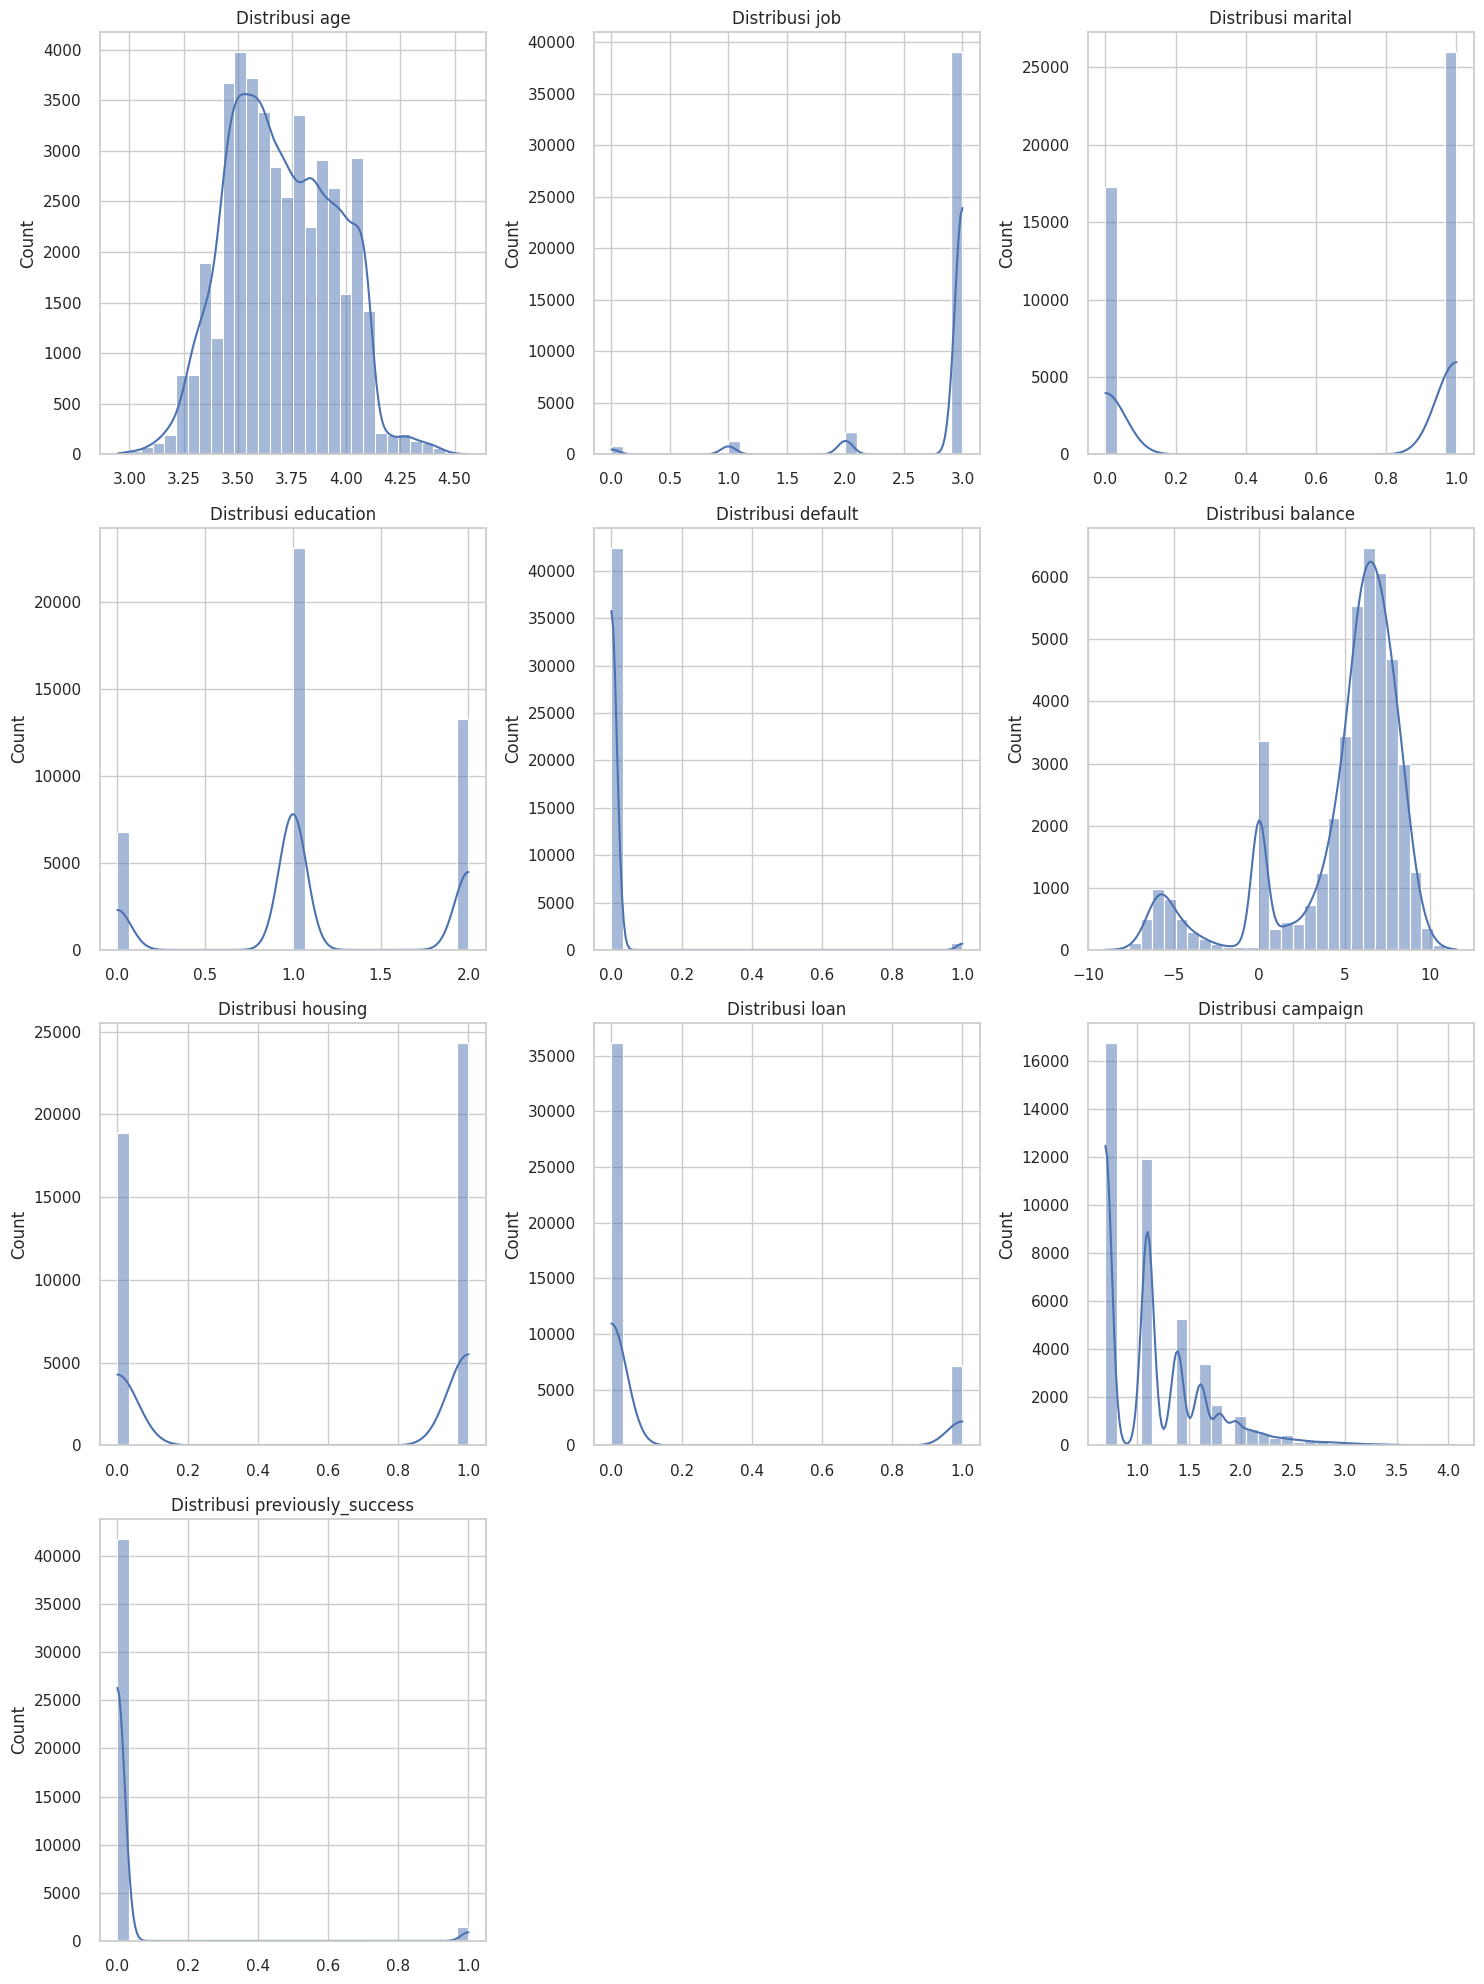

In [39]:
# Visualisasi distribusi data tiap kolom train_df
sns.set(style="whitegrid")
plt.figure(figsize=(15, 20))

for i, column in enumerate(train_df.columns, 1):
    plt.subplot(4, 3, i)

    sns.histplot(train_df[column], kde=True, bins=30)

    plt.title(f'Distribusi {column}')
    plt.xlabel('')
    plt.tight_layout()

plt.show()

## 5. Normalisasi atau Standarisasi Fitur


Normalisasi dan standarisasi dilakukan untuk menyamakan skala dan rentang data agar model mudah memahami pola yang ada. Untuk algoritma K-Means, scaling yang tepat adalah adalah dengan metode Min-Max Scaler.

In [40]:
minmax_scaler = MinMaxScaler()

scaled_values = minmax_scaler.fit_transform(train_df[train_df.columns])
scaled_df = pd.DataFrame(scaled_values, columns=train_df.columns)

In [41]:
scaled_df.describe()

,age,job,marital,education,default,balance,housing,loan,campaign,previously_success
count,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000
mean,0.467339,0.945840,0.600699,0.574804,0.018105,0.675292,0.562406,0.164541,0.137489,0.032968
std,0.151949,0.183404,0.489760,0.332453,0.133332,0.185995,0.496096,0.370770,0.150806,0.178556
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.359231,1.000000,0.000000,0.500000,0.000000,0.646393,0.000000,0.000000,0.000000,0.000000
50%,0.459557,1.000000,1.000000,0.500000,0.000000,0.734920,1.000000,0.000000,0.119804,0.000000
75%,0.584836,1.000000,1.000000,1.000000,0.000000,0.791435,1.000000,0.000000,0.204807,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pertama-tama, dilakukan percobaan awal dengan menggunakan algoritma K-Means tanpa pengaturan hyperparameter tambahan. Model dijalankan dengan menggunakan parameter default dari library sklearn.

Hasil awal menunjukkan Silhouette Score sebesar 0.3279 dengan jumlah cluster sebanyak 8. Nilai ini termasuk rendah, menunjukkan bahwa pemisahan antar cluster belum optimal.

In [42]:
kmeans = KMeans(random_state=42)
clusters = kmeans.fit_predict(scaled_df)

sil_score = silhouette_score(scaled_df, clusters)

print(f"Silhouette Score untuk {kmeans.n_clusters} cluster: {sil_score:.4f}")

Silhouette Score untuk 8 cluster: 0.3279


## **b. Evaluasi Model Clustering**

Selanjutnya, dilakukan visualisasi menggunakan metode elbow untuk menentukan jumlah cluster optimal berdasarkan penurunan nilai inertia. Hasil dari metode elbow menyarankan jumlah cluster optimal adalah 5.

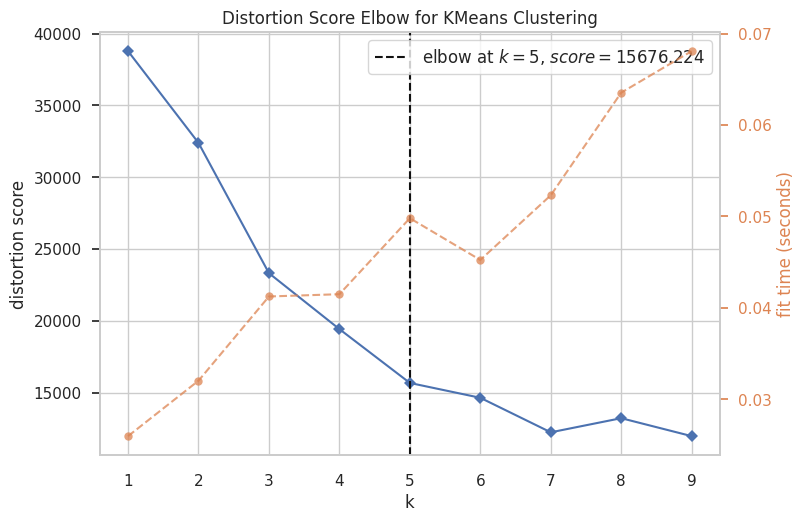

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
# Inisialisasi model KMeans tanpa parameter awal
kmeans = KMeans(random_state=42)

# Inisialisasi visualizer KElbow untuk menentukan jumlah cluster optimal
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

# Fit visualizer dengan data untuk menemukan jumlah cluster optimal
visualizer.fit(scaled_df)

# Menampilkan grafik elbow untuk analisis
visualizer.show()

Model kemudian diinisialisasi ulang menggunakan jumlah cluster = 5.

Hasil:
Silhouette Score untuk 5 cluster: 0.4005
Ini menunjukkan adanya peningkatan, namun model masih dapat dioptimalkan lebih lanjut.

In [44]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_df)

sil_score = silhouette_score(scaled_df, clusters)

print(f"Silhouette Score untuk {kmeans.n_clusters} cluster: {sil_score:.4f}")

Silhouette Score untuk 5 cluster: 0.4005


## **c. Feature Selection (Opsional)**

Untuk meningkatkan kinerja model dan mengurangi kompleksitas, dilakukan seleksi fitur dengan cara:

Menghitung nilai VIF (Variance Inflation Factor) untuk mendeteksi adanya multikolinearitas antar fitur.

Menghapus kolom dengan VIF tinggi atau dianggap kurang relevan untuk analisis penawaran kartu kredit.

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_df.values, i) for i in range(scaled_df.shape[1])]
print(vif_data.sort_values(by='VIF', key=abs, ascending=False))

              feature        VIF
1                 job  17.039473
5             balance  11.496677
0                 age  10.101032
3           education   4.004559
2             marital   2.827084
6             housing   2.380814
8            campaign   1.834281
7                loan   1.225225
9  previously_success   1.057621
4             default   1.057458


Fitur dengan VIF tinggi dihapus (Job) dan fitur yang kurang relevan juga akan dihapus (marital, education, campaign). Alasannya adalah informasi status hubungan pernikahan, tingkat pendidikan, dan berapa banyak lama penawaran yang dilakukan kurang signifikan dalam menentukan nasabah potensial atau tidak.

In [46]:
train_df = train_df.drop('job', axis=1)
train_df = train_df.drop('marital', axis=1)
train_df = train_df.drop('education', axis=1)
train_df = train_df.drop('campaign', axis=1)

Scaling dilakukan untuk memastikan semua fitur berkontribusi seimbang dalam perhitungan jarak.


In [47]:
train_scaler = MinMaxScaler()

scaled_values = train_scaler.fit_transform(train_df[train_df.columns])
train_scaled_df = pd.DataFrame(scaled_values, columns=train_df.columns)

In [48]:
train_scaled_df.describe()

,age,default,balance,housing,loan,previously_success
count,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000,43193.000000
mean,0.467339,0.018105,0.675292,0.562406,0.164541,0.032968
std,0.151949,0.133332,0.185995,0.496096,0.370770,0.178556
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.359231,0.000000,0.646393,0.000000,0.000000,0.000000
50%,0.459557,0.000000,0.734920,1.000000,0.000000,0.000000
75%,0.584836,0.000000,0.791435,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Setelah fitur diseleksi dan dataset diskalakan, metode elbow kembali digunakan. Hasil menunjukkan bahwa jumlah cluster optimal adalah 3.

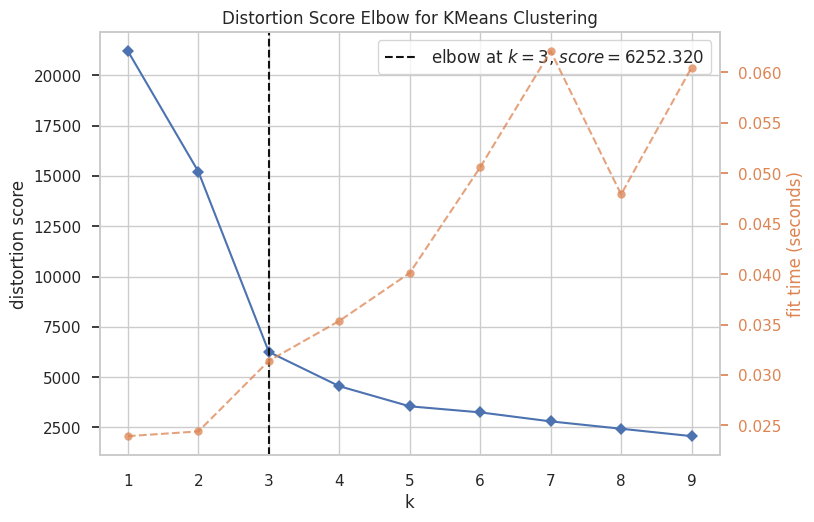

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
# Inisialisasi model KMeans tanpa parameter awal
kmeans = KMeans(random_state=42)

# Inisialisasi visualizer KElbow untuk menentukan jumlah cluster optimal
visualizer = KElbowVisualizer(kmeans, k=(1, 10))

# Fit visualizer dengan data untuk menemukan jumlah cluster optimal
visualizer.fit(train_scaled_df)

# Menampilkan grafik elbow untuk analisis
visualizer.show()

Model diinisialisasi ulang dengan jumlah cluster = 3.

Hasil:
Silhouette Score untuk 3 cluster: 0.6305
Peningkatan signifikan dari sebelumnya, namun masih dimungkinkan untuk peningkatan lebih lanjut melalui optimasi hyperparameter.

In [50]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(train_scaled_df)

sil_score = silhouette_score(train_scaled_df, clusters)

print(f"Silhouette Score untuk {kmeans.n_clusters} cluster: {sil_score:.4f}")

Silhouette Score untuk 3 cluster: 0.6305


## **d. Hyperparameter Tuning**

Untuk mendapatkan parameter terbaik dari model K-Means, digunakan pendekatan Bayesian Optimization melalui BayesSearchCV.
Fungsi evaluasi yang digunakan adalah Silhouette Score. Proses tuning dilakukan sebanyak 50 iterasi. Hasil terbaik dapat dilihat pada output di bawah ini, yaitu jumlah cluster adalah 5 dengan nilai Silhouette Score 0.7209

In [51]:
# Definisi parameter space
param_space = {
    'n_clusters': Integer(2, 9),
    'init': Categorical(['k-means++', 'random']),
    'n_init': Integer(2, 30),
    'max_iter': Integer(1, 500)
}

# Fungsi evaluasi (bisa diganti dengan metric lain)
def eval_function(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Bayesian Optimization
opt = BayesSearchCV(
    estimator=KMeans(random_state=42),
    search_spaces=param_space,
    scoring=eval_function,
    n_iter=50,
    random_state=42,
    n_jobs=-1
)

opt.fit(train_scaled_df)

# Hasil terbaik
print(f"Best parameters: {opt.best_params_}")
print(f"Best Silhouette Score: {opt.best_score_:.4f}")

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('random'), np.int64(500), np.int64(5), np.int64(29)] before, using random point ['k-means++', np.int64(3), np.int64(4), np.int64(20)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('random'), np.int64(500), np.int64(5), np.int64(29)] before, using random point ['k-means++', np.int64(3), np.int64(7), np.int64(2)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('random'), np.int64(500), np.int64(5), np.int64(30)] before, using random point ['k-means++', np.int64(312), np.int64(2), np.int64(6)]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.

Best parameters: OrderedDict([('init', 'k-means++'), ('max_iter', 2), ('n_clusters', 5), ('n_init', 23)])
Best Silhouette Score: 0.6942


In [52]:
best_params = {
    'init': 'k-means++',
    'max_iter': 2,
    'n_clusters': 5,
    'n_init':23,
    'random_state': 42
}

In [53]:
from sklearn.model_selection import cross_val_score

# Inisialisasi model dengan parameter terbaik
best_kmeans = KMeans(**best_params)

# Training model
best_clusters = best_kmeans.fit_predict(train_scaled_df)

best_sil_score = silhouette_score(train_scaled_df, best_clusters)

print(f"Silhouette Score untuk {best_kmeans.n_clusters} cluster: {best_sil_score:.4f}")

Silhouette Score untuk 5 cluster: 0.7029


## **e. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Untuk mempermudah interpretasi hasil clustering, dilakukan reduksi dimensi menggunakan PCA dari data berdimensi tinggi (setelah seleksi fitur dan scaling) menjadi 2 dimensi utama: Principal Component 1 dan 2. Kemudian, visualisasi dilakukan menggunakan scatter plot dengan pewarnaan berdasarkan label cluster hasil K-Means.

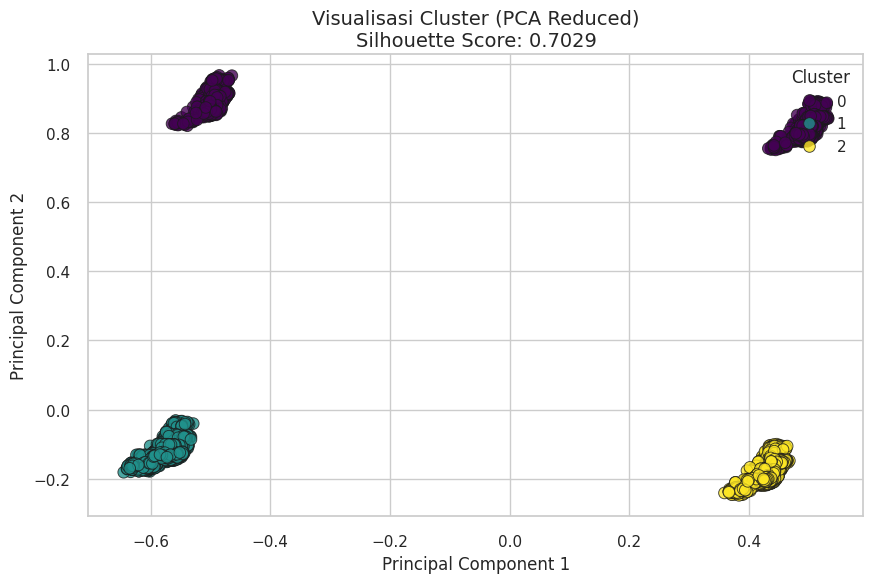

In [54]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_scaled_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=clusters,
    palette='viridis',
    alpha=0.8,
    edgecolor='k',
    s=70
)
plt.title(f"Visualisasi Cluster (PCA Reduced)\nSilhouette Score: {best_sil_score:.4f}", fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)
plt.show()

**Metode Reduksi Dimensi:** Principal Component Analysis (PCA) digunakan untuk mereduksi fitur menjadi 2 komponen utama agar dapat divisualisasikan secara 2D.

**Silhouette Score: 0.7209**

Menunjukkan pemisahan antar cluster yang cukup baik dan stabil, dengan nilai di atas 0.70 menandakan bahwa masing-masing data relatif cocok berada di dalam clusternya.

**Interpretasi Visualisasi:**

* Data terdistribusi dalam tiga cluster utama (0, 1, 2) dengan batas yang jelas dan tidak banyak tumpang tindih.

* Cluster tersebar dengan baik di ruang vektor 2D tanpa overlap signifikan, yang mengindikasikan pemisahan alami antar segmen pelanggan.

* PCA berhasil memproyeksikan data berdimensi tinggi ke dalam ruang yang informatif.

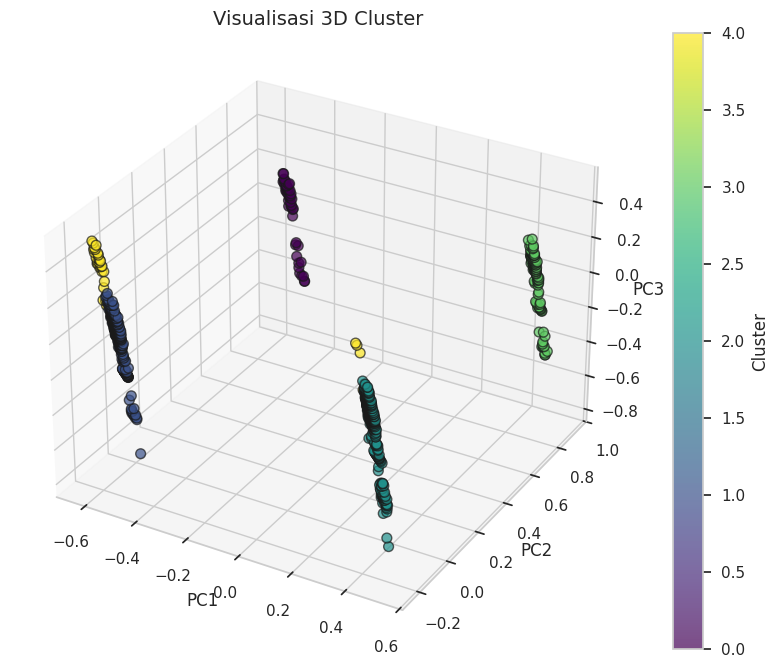

In [55]:
# Visualisasi 3D (Opsional)
from mpl_toolkits.mplot3d import Axes3D

pca3d = PCA(n_components=3)
X_pca3d = pca3d.fit_transform(train_scaled_df)
clusters = best_kmeans.fit_predict(train_scaled_df)

sample_idx = np.random.choice(len(train_scaled_df), size=1000, replace=False)
X_pca_sample = X_pca3d[sample_idx]
clusters_sample = clusters[sample_idx]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_sample[:, 0],
    X_pca_sample[:, 1],
    X_pca_sample[:, 2],
    c=clusters_sample,
    cmap='viridis',
    alpha=0.7,
    edgecolor='k',
    s=50
)

ax.set_title('Visualisasi 3D Cluster', fontsize=14)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()

**Metode Reduksi Dimensi:** PCA dengan 3 komponen digunakan untuk eksplorasi lebih lanjut distribusi cluster secara spasial.

**Pengambilan Sampel:** Untuk mengurangi beban visualisasi, 1000 sampel acak digunakan dari keseluruhan data.

**Interpretasi Visualisasi:**

* Titik-titik cluster terdistribusi di ruang 3D (PC1, PC2, PC3) dan membentuk struktur pemisahan yang lebih kompleks dibandingkan 2D.

* Visualisasi 3D ini menunjukkan bahwa beberapa cluster dapat dibedakan lebih baik di ruang tiga dimensi.

* Peta warna (color bar) menunjukkan label cluster dari hasil K-Means.

* Terlihat beberapa cluster membentuk kolom atau bidang yang cukup rapat, mengindikasikan kohesi internal cluster yang baik.

* Ini mengonfirmasi bahwa segmentasi yang dilakukan oleh algoritma memiliki struktur yang kuat bahkan dalam representasi multi-dimensi.

## **e. Analisis dan Interpretasi Hasil Cluster**

### Inversi Data ke bentuk asli

Setelah berhasil membangun model, kita akan mengembalikan data ke bentuk aslinya, baik sebaran data aslinya atau bahkan nilai asli data tersebut. Proses terakhir yang kita lakukan adalah scaling. Oleh karena itu, langkah pertama yang dilakukan intuk inverse data adalag dengan inverse_transform scaling dengan library.

In [56]:
clustered_data_scaled = train_scaled_df[train_scaled_df.columns].copy()

clustered_data_original = train_scaler.inverse_transform(clustered_data_scaled)
clustered_df = pd.DataFrame(clustered_data_original, columns=train_scaled_df.columns)
clustered_df

,age,default,balance,housing,loan,previously_success
0,4.077537,0.0,7.670429,1.0,0.0,0.0
1,3.806662,0.0,3.401197,1.0,0.0,0.0
2,3.526361,0.0,1.098612,1.0,1.0,0.0
3,3.583519,0.0,5.446737,1.0,0.0,0.0
4,3.367296,0.0,6.104793,1.0,1.0,0.0
...,...,...,...,...,...,...
43188,3.951244,0.0,6.716595,0.0,0.0,0.0
43189,4.276666,0.0,7.455877,0.0,0.0,0.0
43190,4.290459,0.0,8.651025,0.0,0.0,1.0
43191,4.060443,0.0,6.505784,0.0,0.0,0.0


Setelah dilakukan inverse scaling, selanjutnya adalah mengembalikan transformasi data numerikal age dan balance ke sebaran data aslinya dengan menggunakan fungsi kebalikannya.

In [57]:
clustered_df['age'] = np.sign(clustered_df['age']) * (np.exp(np.abs(clustered_df['age'])) - 1)
clustered_df['balance'] = np.sign(clustered_df['balance']) * (np.exp(np.abs(clustered_df['balance'])) - 1)

Untuk kolom kategorikal, dilakukan mapping secara terbalik dari sebelumnya untuk semua kolom.

In [58]:
mapping = {1:'yes', 0:'no'}
clustered_df['default'] = clustered_df['default'].map(mapping)

In [59]:
mapping = {1:'yes', 0:'no'}
clustered_df['housing'] = clustered_df['housing'].map(mapping)

In [60]:
mapping = {1:'yes', 0:'no'}
clustered_df['loan'] = clustered_df['loan'].map(mapping)

In [61]:
mapping = {1:'yes', 0:'no'}
clustered_df['previously_success'] = clustered_df['previously_success'].map(mapping)

Setelah data dikembalikan ke bentuk semula, terakhir kita dapat menambahkan label untuk tiap baris data yang dihasilkan dari model clustering.

In [62]:
clustered_df['cluster'] = best_kmeans.labels_

In [63]:
clustered_df.describe(include='all')

,age,default,balance,housing,loan,previously_success,cluster
count,43193.000000,43193,43193.000000,43193,43193,43193,43193.000000
unique,NaN,2,NaN,2,2,2,NaN
top,NaN,no,NaN,yes,no,no,NaN
freq,NaN,42411,NaN,24292,36086,41769,NaN
mean,40.764082,NaN,1354.027342,NaN,NaN,NaN,1.680527
std,10.512640,NaN,3042.103625,NaN,NaN,NaN,0.856436
min,18.000000,NaN,-8019.000000,NaN,NaN,NaN,0.000000
25%,33.000000,NaN,71.000000,NaN,NaN,NaN,1.000000
50%,39.000000,NaN,442.000000,NaN,NaN,NaN,2.000000
75%,48.000000,NaN,1412.000000,NaN,NaN,NaN,2.000000


### Interpretasi

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Untuk itu, kita akan mengumpulkan informasi tiap cluster dari karakteristik masing-maisng kolom. Untuk kolom numerikal, kita akan mencari rata-rata cluster tersebut dan untuk kolom kategorikal akan dicari modusnya.

In [64]:
numerical_cols = ['age', 'balance']
categorical_cols = ['default', 'housing', 'loan', 'previously_success']

numerical_means = clustered_df.groupby('cluster')[numerical_cols].mean()

categorical_modes = clustered_df.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0])

cluster_summary = pd.concat([clustered_df['cluster'].value_counts(), numerical_means, categorical_modes], axis=1)
cluster_summary

,count,age,balance,default,housing,loan,previously_success
cluster,,,,,,,
2,19590,38.990097,1249.230015,no,yes,no,no
1,15150,43.003894,1706.136502,no,no,no,no
3,4291,39.310650,791.053601,no,yes,yes,no
0,2816,42.379261,752.126776,no,no,yes,no
4,1346,42.627043,1970.073551,no,no,no,yes


#### Cluster 0 (Ukuran: 2.816 Pelanggan)

- **Rata-rata Usia:** 42.38 tahun  
- **Rata-rata Saldo:** 752.13  
- **Modus Default:** no  
- **Modus Housing Loan:** no  
- **Modus Personal Loan:** yes  
- **Modus Previously Success:** no  

**Analisis:**  *italicized text*
Cluster ini terdiri dari pelanggan usia menengah dengan saldo yang tergolong rendah dibandingkan rata-rata keseluruhan. Sebagian besar tidak memiliki pinjaman rumah, namun justru memiliki pinjaman pribadi. Tidak banyak dari mereka yang pernah berhasil dalam kontak sebelumnya. Cluster ini mungkin merepresentasikan kelompok berisiko atau perlu bantuan finansial, sehingga cocok untuk ditargetkan dengan produk bantuan keuangan, edukasi finansial, atau penawaran restrukturisasi pinjaman.

#### Cluster 1 (Ukuran: 15.150 Pelanggan)

- **Rata-rata Usia:** 43.00 tahun  
- **Rata-rata Saldo:** 1.706,14  
- **Modus Default:** no  
- **Modus Housing Loan:** no  
- **Modus Personal Loan:** no  
- **Modus Previously Success:** no  

**Analisis:**  
Cluster ini memiliki usia rata-rata yang relatif serupa dengan Cluster 0, namun dengan saldo yang lebih tinggi. Mereka cenderung tidak memiliki pinjaman dan belum pernah berhasil dalam interaksi sebelumnya. Karakteristik ini menunjukkan kelompok pelanggan dengan kestabilan finansial, tetapi minim keterlibatan dalam layanan. Potensial untuk dikembangkan melalui program engagement seperti reward, loyalitas, atau produk investasi ringan.


#### Cluster 2 (Ukuran: 19.590 Pelanggan)

- **Rata-rata Usia:** 38.99 tahun  
- **Rata-rata Saldo:** 1.249,23  
- **Modus Default:** no  
- **Modus Housing Loan:** yes  
- **Modus Personal Loan:** no  
- **Modus Previously Success:** no  

**Analisis:**  
Merupakan cluster dengan usia rata-rata termuda. Saldo berada sedikit di bawah rata-rata keseluruhan. Mayoritas memiliki pinjaman rumah, tapi tidak memiliki pinjaman pribadi. Mereka juga belum banyak berhasil dalam kampanye sebelumnya. Cluster ini mewakili segmen keluarga muda atau pekerja muda yang baru memulai pembelian aset. Cocok untuk penawaran produk jangka panjang seperti asuransi, investasi pensiun, atau refinancing properti.

#### Cluster 3 (Ukuran: 4.291 Pelanggan)
- **Rata-rata Usia:** 39.31 tahun  
- **Rata-rata Saldo:** 791.05  
- **Modus Default:** no  
- **Modus Housing Loan:** yes  
- **Modus Personal Loan:** yes  
- **Modus Previously Success:** no  

**Analisis:**  
Cluster ini memiliki usia yang cukup muda, namun dengan saldo yang rendah. Mayoritas memiliki dua jenis pinjaman sekaligus (housing dan personal loan). Belum ada interaksi yang sukses di masa lalu. Ini mengindikasikan kelompok yang terbebani kewajiban finansial dan berisiko menurunkan loyalitas jika tidak ditangani. Cocok untuk ditargetkan dengan produk restrukturisasi utang, cicilan ringan, atau konsolidasi pinjaman.

#### Cluster 4 (Ukuran: 1.346 Pelanggan)
- **Rata-rata Usia:** 42.63 tahun  
- **Rata-rata Saldo:** 1.970,07  
- **Modus Default:** no  
- **Modus Housing Loan:** no  
- **Modus Personal Loan:** no  
- **Modus Previously Success:** yes  

**Analisis:**  
Ini adalah cluster paling eksklusif dan kecil. Mereka memiliki saldo tertinggi di antara semua cluster dan memiliki riwayat interaksi sukses sebelumnya. Tidak memiliki pinjaman menunjukkan kestabilan atau kehati-hatian dalam keuangan. Usia pun relatif matang. Cluster ini adalah target ideal untuk produk premium, investasi jangka panjang, layanan prioritas, atau loyalty program tingkat tinggi.

### Rekomendasi dan Strategi Bisnis


**CLuster 0:**

**Rekomendasi Penawaran Kartu Kredit:**
Nasabah dalam cluster ini kurang ideal untuk penawaran premium karena saldo rendah dan sudah memiliki pinjaman pribadi.
Namun, mereka bisa ditargetkan dengan kartu kredit berlimit rendah, fitur cicilan ringan, atau program cashback untuk kebutuhan dasar, misalnya untuk belanja bulanan atau pembayaran tagihan.

**Strategi:**

* Edukasi manfaat kartu kredit untuk pengelolaan cash flow

* Bundling dengan program pelunasan pinjaman (misal: poin reward bisa digunakan bayar tagihan)

* Hindari biaya tahunan tinggi



**CLuster 1:**

**Rekomendasi Penawaran Kartu Kredit:**
Segmen ini menarik karena saldo cukup stabil dan tidak terbebani pinjaman, meskipun tingkat engagement sebelumnya rendah.
Mereka cocok untuk kartu kredit reguler dengan manfaat menarik, seperti diskon merchant, reward point, dan tanpa iuran tahunan di tahun pertama.


**Strategi:**

* Kampanye berbasis edukasi penggunaan kartu kredit secara bijak

* Penawaran personalisasi via mobile banking

* Program referral untuk tingkatkan akuisisi dan keterlibatan



**CLuster 2:**

**Rekomendasi Penawaran Kartu Kredit:**
Segmen keluarga muda atau first-time homeowners. Mereka berpotensi tertarik dengan kartu kredit untuk kebutuhan rumah tangga atau pengeluaran rutin keluarga.


**Strategi:**

* Kartu kredit dengan cicilan 0% untuk perabotan, elektronik, atau kebutuhan rumah

* Penawaran partner e-commerce dan supermarket

* Limit sedang dan fitur budget tracking



**CLuster 3:**

**Rekomendasi Penawaran Kartu Kredit:**
Segmen ini berisiko tinggi, karena beban pinjaman besar dan saldo kecil. Tidak disarankan diberikan kartu kredit kecuali dalam kondisi sangat terkendali.

**Strategi:**

* Kartu debit-kredit hybrid (berbasis saldo, bukan limit)

* Kartu kredit dengan limit sangat kecil dan penggunaan terbatas

* Sertakan fitur edukasi keuangan dan pengingat tagihan otomatis



**CLuster 4:**

**Rekomendasi Penawaran Kartu Kredit:**
Cluster paling premium. Stabil secara finansial, loyal, dan punya pengalaman sukses sebelumnya. Ideal untuk penawaran kartu kredit premium, gold, atau platinum.

**Strategi:**

* Kartu kredit dengan benefit eksklusif: airport lounge, miles, asuransi perjalanan

* Kartu dengan cashback besar untuk kategori lifestyle (travel, dining, shopping)

* Program loyalitas dan concierge service

* Akses ke event khusus nasabah prioritas





### Kesimpulan


| Cluster | Target Penawaran Kartu Kredit                      | Limit         | Benefit Fokus                 | Risiko |
|---------|----------------------------------------------------|---------------|-------------------------------|--------|
| 0       | Kartu kredit basic dengan fitur cicilan ringan     | Rendah        | Cashback, tanpa iuran         | Sedang |
| 1       | Kartu reguler dengan reward & diskon merchant      | Sedang        | Diskon, poin, edukasi         | Rendah |
| 2       | Kartu keluarga muda, cicilan kebutuhan rumah       | Sedang        | Cicilan 0%, belanja rumah     | Rendah |
| 3       | Kartu hybrid atau prabayar, jika perlu             | Sangat Rendah | Kontrol keuangan              | Tinggi |
| 4       | Kartu gold/premium untuk loyalis                   | Tinggi        | Miles, VIP service            | Rendah |


# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [65]:
clustered_df.to_csv("credit_terms_clustered.csv", index=False)